In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [3]:
class FashionNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_size):
        super(FashionNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layers = hidden_layers
        self.hidden_size = hidden_size

        self.layers = nn.ModuleList([nn.Linear(input_size, hidden_size)])

        for _ in range(hidden_layers):
            self.layers.extend([nn.Linear(hidden_size, hidden_size)])

        self.layers.append(nn.Linear(hidden_size, output_size))

    def forward(self, x):
        #pixele do jednowymiarowej macierzy
        x = x.view(-1, self.input_size)
        for layer in self.layers:
            x = torch.relu(layer(x))
        return x


In [4]:
# obrazy w Tensor object
mean = 0.5
std_dev = 0.5
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std_dev,))])

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
# train_data, val_data = train_test_split(trainset, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(trainset, train_size=0.1, random_state=42)



In [11]:
def add_gaussian_noise(batch, mean=0, std=2):
    noise = torch.randn_like(batch) * std + mean
    return batch + noise

In [14]:
import matplotlib.pyplot as plt
batch = 256
trainloader = DataLoader(trainset, batch_size=batch, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch, shuffle=True)

input_size = 28 * 28  # pixele
output_size = 10  # 10 klas
hidden_layers = 1
hidden_size = 25

model = FashionNN(input_size, output_size, hidden_layers, hidden_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

loss_values = []
val_loss_values = []
epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        optimizer.zero_grad()
        images_with_noise = add_gaussian_noise(images)        #dodawanie szumu
        outputs = model(images_with_noise)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} - Training Loss: {running_loss/len(trainloader)}")
    loss_values.append(running_loss/len(trainloader))

    # validation loss
    val_running_loss = 0.0
    model.eval()  # evaluation mode
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images_with_noise = add_gaussian_noise(val_images)      #dodawanie szumu
            val_outputs = model(val_images_with_noise)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
        val_loss_values.append(val_running_loss/len(val_loader))
        print(f"Epoch {epoch+1} - Validation Loss: {val_running_loss/len(val_loader)}")
    model.train()


correct = 0
total = 0
with torch.no_grad():
    for images, labels in trainloader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Final Accuracy: {accuracy:.4f}")

Epoch 1 - Training Loss: 2.261876393379049
Epoch 1 - Validation Loss: 2.1763834512629217
Epoch 2 - Training Loss: 1.947101078134902
Epoch 2 - Validation Loss: 1.649366766920587
Epoch 3 - Training Loss: 1.5328993487865368
Epoch 3 - Validation Loss: 1.457758637401165
Epoch 4 - Training Loss: 1.4115836914549482
Epoch 4 - Validation Loss: 1.3736296547532647
Epoch 5 - Training Loss: 1.3433733473432825
Epoch 5 - Validation Loss: 1.3204475081927403
Final Accuracy: 0.5917


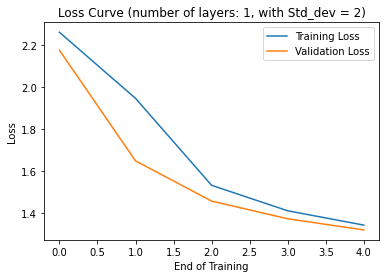

In [15]:
plt.plot(range(0, epochs), loss_values, label='Training Loss')
plt.plot(range(0, epochs), val_loss_values, label='Validation Loss')
plt.xlabel('End of Training')
plt.ylabel('Loss')
plt.title(f'Loss Curve (number of layers: {hidden_layers}, with Std_dev = 2)')
plt.legend()
plt.show()